<a href="https://colab.research.google.com/github/gsamp/ml-algs/blob/main/ml_algs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# main imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from numpy.linalg import norm

# model setup, training utils
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

# debug
import pdb

# First Stage

## Regression

### **Dataset**

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
n = 500
d = 1
x = np.random.uniform(low=0, high=20, size=(n, d))
y = x * np.abs(np.sin(x)) + x + np.random.normal(loc=0, scale=1.0, size=(n, d))

# 75/25 train/val split
x_train = torch.Tensor(x[:int(len(x)*0.75)])
x_val = torch.Tensor(x[int(len(x)*0.75):])

y_train = torch.Tensor(y[:int(len(y)*0.75)])
y_val = torch.Tensor(y[int(len(y)*0.75):])

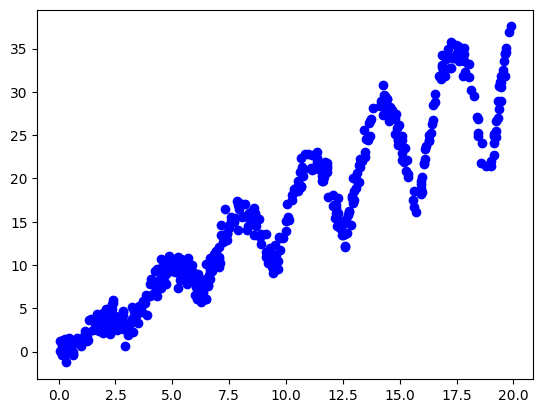

In [ ]:
plt.scatter(x, y, c ="blue")

### **Linear Regression with Linear Function Approximation**

In [ ]:
# y = W*x + b
# 1 =  (1, d) (d, 1)     1
#      (a, b) * (b, a) = (a, a)

class LinearModel(nn.Module):
    def __init__(self):
        # initializes using parent method
        super().__init__()
        # set up linear model params
        self.W = nn.Parameter(torch.randn(d, 1))
        self.b = nn.Parameter(torch.randn(d))

    # define the linear function that we are using to approximate the dataset
    def forward(self, x):
        # assert it's 2-dimensional
        assert len(x.shape) == 2
        assert x.shape[1] == d
        # import pdb; pdb.set_trace()
        return x @ self.W + self.b

In [ ]:
# (y_pred - y)^2 / n

def loss(y_pred, y):
    assert len(y.shape) == 1
    assert len(y_pred.shape) == 1
    # this is the same as dividing by n but cleaner
    # we specify the dimension so torch doesnt squash them
    return torch.square(y_pred - y).mean(dim=0)

m = 10
y_pred = torch.randn(m)
y_target = torch.randn(m)
assert F.mse_loss(y_pred, y_target, reduction='mean') == loss(y_pred, y_target)

In [ ]:
num_epochs = 1000
batch_size = 10
lr = 0.005

def train(model):
    optimizer = optim.SGD(model.parameters(), lr = lr)
    print(f'Loss before: {F.mse_loss(model(x_val), y_val, reduction="mean")}')

    for epoch_index in tqdm(range(num_epochs)):
        index = 0
        while index + batch_size < x_train.shape[0]:
            x_batch = x_train[index:index + batch_size]
            y_batch = y_train[index:index + batch_size]
            index += batch_size

            l = F.mse_loss(model(x_batch), y_batch, reduction="mean")
            optimizer.zero_grad()

            l.backward()
            optimizer.step()

        if epoch_index % 100 == 0:
            print(f'Loss after: {F.mse_loss(model(x_val), y_val, reduction="mean")}')

    print(f'Loss after: {F.mse_loss(model(x_val), y_val, reduction="mean")}')

model = LinearModel()
train(model)

Loss before: 101.95079040527344


  1%|          | 6/1000 [00:00<00:16, 58.84it/s]

Loss after: 13.015144348144531


 11%|█         | 108/1000 [00:01<00:16, 55.52it/s]

Loss after: 12.868857383728027


 21%|██        | 207/1000 [00:04<00:19, 41.09it/s]

Loss after: 12.868878364562988


 31%|███       | 311/1000 [00:06<00:12, 55.92it/s]

Loss after: 12.868878364562988


 41%|████      | 412/1000 [00:08<00:10, 54.60it/s]

Loss after: 12.868878364562988


 51%|█████     | 508/1000 [00:10<00:08, 57.83it/s]

Loss after: 12.868878364562988


 61%|██████    | 612/1000 [00:12<00:06, 58.51it/s]

Loss after: 12.868878364562988


 71%|███████   | 711/1000 [00:13<00:04, 57.98it/s]

Loss after: 12.868878364562988


 81%|████████  | 810/1000 [00:15<00:03, 53.43it/s]

Loss after: 12.868878364562988


 91%|█████████ | 906/1000 [00:17<00:02, 43.00it/s]

Loss after: 12.868878364562988


100%|██████████| 1000/1000 [00:19<00:00, 50.76it/s]

Loss after: 12.868878364562988


(500, 1) (500, 1)
torch.Size([125, 1]) torch.Size([125, 1])


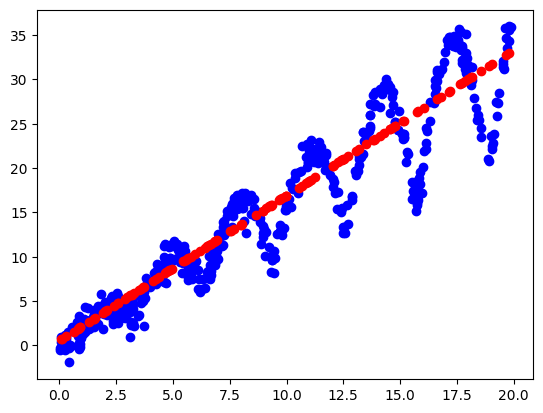

In [ ]:
assert y.shape == x.shape
plt.scatter(x, y, c ="blue")

assert x_val.shape == y_val.shape
plt.scatter(x_val, model(x_val).detach().numpy(), c="red")

### **Gaussian MLE with Linear Parameter Approximation**

In [ ]:
from torch.distributions import Normal

class GaussianModel(nn.Module):
    def __init__(self):
        # initializes using parent method
        super().__init__()
        # set up  model params
        self.W = nn.Parameter(torch.randn(d, 1))
        self.b = nn.Parameter(torch.randn(d))
        self.var = nn.Parameter(torch.ones(1))

    # Given data (features), returns predicted output (labels)
    # In this case, return the distribution because we want to be able to compute the
    # probability of the true label under that distribution
    def forward(self, x):
        return Normal(x @ self.W + self.b, torch.sqrt(self.var))

In [ ]:
# returns negative log likelihood loss
def loss(y_pred, y):
    return -1 * y_pred.log_prob(y).mean(dim=0)

In [ ]:
num_epochs = 1000
batch_size = 10
lr = 0.05

def train(model):
    optimizer = optim.SGD(model.parameters(), lr = lr)
    print(f'Loss before: {loss(model(x_val), y_val)}')

    for epoch_index in tqdm(range(num_epochs)):
        index = 0
        while index + batch_size < x_train.shape[0]:
            x_batch = x_train[index:index + batch_size]
            y_batch = y_train[index:index + batch_size]
            index += batch_size

            l = loss(model(x_batch), y_batch)
            optimizer.zero_grad()

            l.backward() # retain_graph=True
            optimizer.step()

        if epoch_index % 100 == 0:
            print(f'Loss after: {loss(model(x_batch), y_batch)}')

    print(f'Loss after: {loss(model(x_val), y_val)}')

model = GaussianModel()
train(model)

Loss before: tensor([58.1113], grad_fn=<MulBackward0>)


  0%|          | 2/1000 [00:00<00:58, 17.06it/s]

Loss after: tensor([2.5817], grad_fn=<MulBackward0>)


 10%|█         | 104/1000 [00:03<00:33, 26.69it/s]

Loss after: tensor([2.5741], grad_fn=<MulBackward0>)


 20%|██        | 203/1000 [00:08<00:41, 19.19it/s]

Loss after: tensor([2.5779], grad_fn=<MulBackward0>)


 31%|███       | 306/1000 [00:12<00:24, 28.58it/s]

Loss after: tensor([2.5800], grad_fn=<MulBackward0>)


 40%|████      | 405/1000 [00:16<00:20, 29.32it/s]

Loss after: tensor([2.5811], grad_fn=<MulBackward0>)


 50%|█████     | 503/1000 [00:19<00:16, 30.26it/s]

Loss after: tensor([2.5816], grad_fn=<MulBackward0>)


 61%|██████    | 606/1000 [00:23<00:13, 28.71it/s]

Loss after: tensor([2.5819], grad_fn=<MulBackward0>)


 70%|███████   | 704/1000 [00:27<00:09, 30.30it/s]

Loss after: tensor([2.5820], grad_fn=<MulBackward0>)


 80%|████████  | 804/1000 [00:30<00:06, 30.25it/s]

Loss after: tensor([2.5821], grad_fn=<MulBackward0>)


 90%|█████████ | 903/1000 [00:34<00:04, 23.14it/s]

Loss after: tensor([2.5822], grad_fn=<MulBackward0>)


100%|██████████| 1000/1000 [00:38<00:00, 26.30it/s]

Loss after: tensor([2.6874], grad_fn=<MulBackward0>)


<ErrorbarContainer object of 3 artists>

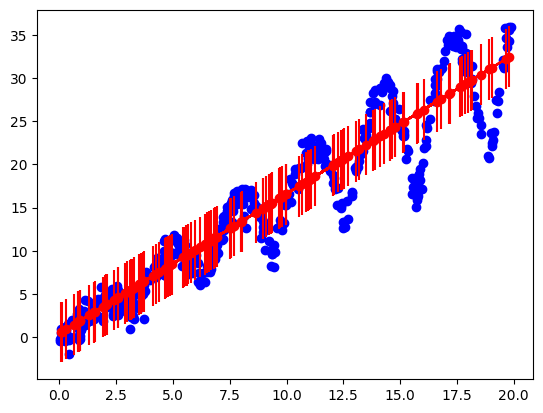

In [ ]:
assert y.shape == x.shape
plt.scatter(x, y, c ="blue")

assert x_val.numpy().shape == y_val.numpy().shape

plt.scatter(x_val, model(x_val).loc.detach().numpy(), c="red")
plt.errorbar(x_val, model(x_val).loc.reshape(-1).detach().numpy(), yerr=model(x_val).scale.mean().detach().numpy(), c="red")

## Neural Network: Arbitrary Function Approximator

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, activation_fn, input_size):
        super().__init__()
        # get model architecture parameters
        assert num_hidden_layers != 0, "Please input a nonzero number of hidden layers"
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn

        # wire together the layers
        layers = nn.ModuleList()
        layers.append(nn.Linear(input_size, self.hidden_size))
        for layer in range(self.num_hidden_layers):
            if layer == self.num_hidden_layers - 1:
                layers.append(nn.Linear(self.hidden_size, output_size))
                # since activation_fn is ReLU, we are not adding it here so we can return values < 0
            else:
                layers.append(nn.Linear(self.hidden_size, self.hidden_size))
                layers.append(activation_fn)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x_and_x_squared = torch.concatenate([x, torch.square(x)], dim=1)
        return self.layers(x_and_x_squared)

In [ ]:
def train(model, optimizer):
    print('Before')
    print(f'Train loss (over entire dataset): {F.l1_loss(model(x_train), y_train, reduction="mean")}')
    print(f'Val loss: {F.l1_loss(model(x_val), y_val, reduction="mean")}')

    for epoch_index in tqdm(range(num_epochs)):
        index = 0
        while index + batch_size < x_train.shape[0]:
            x_batch = x_train[index:index + batch_size]
            y_batch = y_train[index:index + batch_size]
            index += batch_size

            l = F.l1_loss(model(x_batch), y_batch, reduction="mean")
            optimizer.zero_grad()

            l.backward()
            optimizer.step()

        if epoch_index % 100 == 0:
            print(f'Train loss (last batch): {F.l1_loss(model(x_batch), y_batch, reduction="mean")}')
            print(f'Val loss: {F.l1_loss(model(x_val), y_val, reduction="mean")}')

    print('After')
    print(f'Train loss (over entire dataset): {F.l1_loss(model(x_train), y_train, reduction="mean")}')
    print(f'Val loss: {F.l1_loss(model(x_val), y_val, reduction="mean")}')

In [ ]:
# model params
num_hidden_layers = 10
hidden_size = 64
activation_fn = nn.ReLU()
input_size = 2
output_size = 1
batch_size = 100

# training hyperparams
num_epochs = 7000
lr = 0.0005

# train
model = NeuralNetwork(num_hidden_layers, hidden_size, activation_fn, input_size)
optimizer = optim.SGD(params=model.parameters(), lr = lr)
train(model, optimizer)

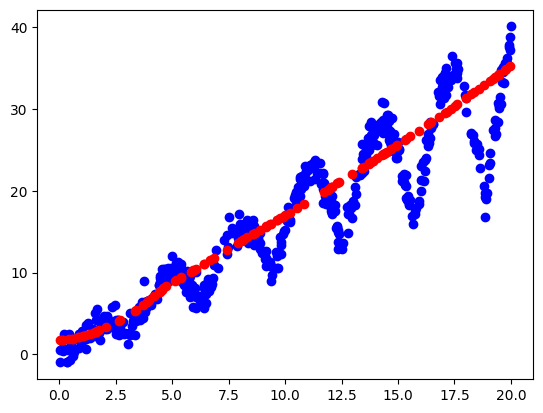

In [ ]:
plt.clf()

assert y.shape == x.shape
plt.scatter(x, y, c ="blue")

assert x_val.shape == y_val.shape
plt.scatter(x_val, model(x_val).detach().numpy(), c="red")

## **Loss Functions**

In [ ]:
# generate data
x = np.random.uniform(low=0, high=20, size=(n, d))
y_target = x * np.abs(np.sin(x)) + x + np.random.normal(loc=0, scale=1.0, size=(n, d))
y_pred = x * np.abs(np.sin(x)) + x + np.random.normal(loc=0, scale=10.0, size=(n, d))

y_target = torch.Tensor(y_target)
y_pred = torch.Tensor(y_pred)

#### Regression
1. Mean Squared Error Loss
2. Mean Absolute Error Loss

In [ ]:
def mean_squared_error(y_pred, y_target):
    # this is the same as dividing by n but cleaner
    # we specify the dimension so torch doesnt squash them
    return torch.square(y_pred - y_target).mean(dim=0)

assert F.mse_loss(y_pred, y_target, reduction='mean') == mean_squared_error(y_pred, y_target), "MSE does not match"

In [ ]:
def mean_abs_error(y_pred, y_target):
    # this is the same as dividing by n but cleaner
    # we specify the dimension so torch doesnt squash them
    return torch.abs(y_pred - y_target).mean(dim=0)

assert F.l1_loss(y_pred, y_target, reduction='mean') == mean_abs_error(y_pred, y_target), "MAE does not match"

#### Classification
Binary Cross-Entropy

When training a classifier neural network, minimizing the cross-entropy loss during training is equivalent to helping the model learn to predict the correct labels with higher confidence.

- When the true label t is 1, the cross-entropy loss approaches 0 as the predicted probability p approaches 1 and
- When the true label t is 0, the cross-entropy loss approaches 0 as the predicted probability p approaches 0.

When the true and predicted values are closer, the cross-entropy loss is lower; the loss increases when the true and predicted values are different.

In [ ]:
import torch
import torch.nn.functional as F

def binary_cross_entropy(true, pred):
    return - (true * pred.log() + (1 - true) * (1 - pred).log()).mean()

t = torch.tensor([ 0.0,  1.0,  0.0,  0.0,  0.0])
p = torch.tensor([0.07, 0.91, 0.74, 0.23, 0.85])

assert binary_cross_entropy(t, p) == F.binary_cross_entropy(p, t, reduction='mean')
assert binary_cross_entropy(t, torch.sigmoid(p)) == F.binary_cross_entropy(torch.sigmoid(p), t, reduction='mean')

print(binary_cross_entropy(t, p))
print(binary_cross_entropy(t, torch.sigmoid(p)))

tensor(0.7345)
tensor(0.8435)


#### Precision, Recall, F1
- Precision: What proportion of positive identifications was actually correct? How many retrieved items are relevant?  

Precision = $\frac{TP}{TP + FP}$



- Recall: What proportion of actual positives was identified correctly? How many relevant items are retrieved?

Recall = $\frac{TP}{TP + FN}$

- F1: Harmonic mean of precision and recall

F1 = $\frac{2}{\frac{1}{P} + \frac{1}{R}} = \frac{2 * P * R}{P + R}$


## **Activation Functions**

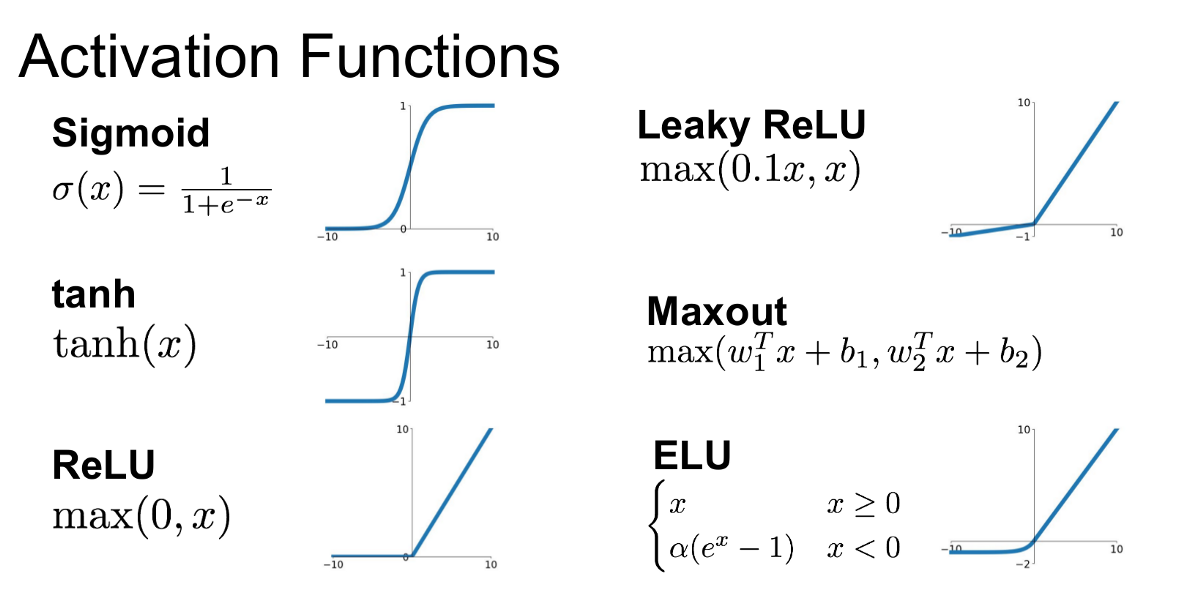

Common issues with some activation functions:

*   Vanishing gradients (Sigmoid, tanh and ReLU): when outputs of the tanh unit are in the flat region of the tanh, gradients don't flow to the previous layers, so learning is impeded.
*   Dead neuron: not a single example "activates" the neuron

## Math

- Describe what convex function is? Why do we want convex functions?
- What is gradient descent?
- What are second-order optimisation algorithms?
- How can the 2nd derivative be used in an optimisation algorithm?
- Describe Newton's method? Where does it come from? How can it be adapted to find a minimum in a function?
- What is the formula for the Taylor series? Why does it make sense? Why is there a 1/n! in the formula?
- What is Bayes' Formula? Can you give an example?
- What is an invertible matrix? What are the criteria that apply? What are the procedures to invert a Matrix? Can you describe the Gauss Process to invert a matrix?
- Q: What is convex function? Q: What is eigenvalue/eigenvectors? Q: Have you trained models that exceed GPU memory usage?

## Classification / Clustering

### **Dataset**

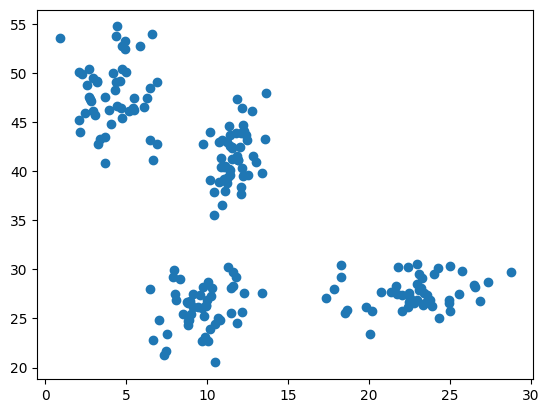

In [ ]:
# sample random n from [5, 10]
num_clusters = random.randint(5, 10)

# for KNN
num_clusters = 4

N = 50
g = np.random.default_rng()

X = []
for i in range(num_clusters):
  means = np.random.random_sample(size=(2)) * 50
  cov_xy = np.random.random_sample()
  var_xx, var_yy = np.random.randint(low=1, high=10, size=(2))
  cov = np.array([[var_xx, cov_xy],
                  [cov_xy, var_yy]])
  pairs = g.multivariate_normal(means, cov, size=N, check_valid='raise')
  X.append(pairs)

X = np.array(X).reshape(num_clusters * N, 2)

# Plot it at the end
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])

### **K-Means**

In [ ]:
# https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

class Kmeans:
  def __init__(self, num_clusters, max_iter, random_seed):
    self.num_clusters = num_clusters
    self.max_iter = max_iter
    self.random_seed = random_seed


  def initialize_centroids(self, X):
    # set the random seed
    np.random.RandomState(self.random_seed)
    # randomly permute the locations of the data points
    random_idx = np.random.permutation(X.shape[0])
    # get the first k random elements as the centroids
    centroids = X[random_idx[:self.num_clusters]]
    return centroids


  def compute_centroids(self, X, labels):
    # initialize centroids of shape (num_clusters, d)
    centroids = np.zeros((self.num_clusters, X.shape[1]))

    # for each cluster i, assign a new centroid value, which is the mean of the points in the current partition
    for i in range(self.num_clusters):
      # print(np.array(X[labels == i, :]))
      centroids[i, :] = np.mean(X[labels == i, :], axis = 0)

    # print("compute centroids: ", centroids)
    return centroids

  def compute_distance(self, X, centroids):
    # initialize distance of shape (N, num_clusters)
    distance = np.zeros((X.shape[0], self.num_clusters))
    # for each cluster (row in centroids but column in distance)
    for i in range(self.num_clusters):
      row_norm = norm(X - centroids[i, :], axis = 1)
      distance[:, i] = np.square(row_norm)
    return distance


  # reduces the dimensionality by picking the closest centroid
  def find_closest_cluster(self, distance):
    return np.argmin(distance, axis = 1)


  # computes the distance between each centroid and the elements that belong to that cluster
  def compute_sum_squared_error(self, X, labels, centroids):
    distance = np.zeros(X.shape[0])
    for i in range(self.num_clusters):
      distance[labels == i] = norm(X[labels == i] - centroids[i, :], axis = 1)
    return np.sum(np.square(distance))


  def fit(self, X):
    self.centroids = self.initialize_centroids(X)
    for i in range(self.max_iter):
      old_centroids = self.centroids
      # get distance for each centroid and each element in X
      distance = self.compute_distance(X, old_centroids) # (500, 3)
      # get the closest
      self.labels = self.find_closest_cluster(distance) # (500,)
      # get new centroids by computing the mean of the elements in the new centroids
      self.centroids = self.compute_centroids(X, self.labels)
      # stop if centroids did not change
      if np.all(old_centroids == self.centroids):
        break
    # compute the distance between each centroid and the elements that belong to that cluster
    self.error = self.compute_sum_squared_error(X, self.labels, self.centroids)

  # assign a centroid for each element in the input
  def predict(self, X):
    distance = self.compute_distance(X, self.centroids)
    return self.find_closest_cluster(distance)


In [ ]:
km = Kmeans(3, 2, 123)
km.fit(X)

### **KNN**

- Does not require any assumptions about the underlying data distribution.
- Can handle both numerical and categorical data, making it a flexible choice for various types of datasets in classification and regression tasks.
- It is a non-parametric method that makes predictions based on the similarity of data points in a given dataset.
- K-NN is less sensitive to outliers compared to other algorithms.

In [ ]:
"""
Let X be the training dataset with n data points,
where each data point is represented by a d-dimensional feature vector X_i
and Y be the corresponding labels or values for each data point in X.
Given a new data point x, the algorithm calculates the distance between x
and each data point X_i in X using a distance metric, such as Euclidean
distance.
"""


def most_common(lst):
  return max(set(lst), key = lst.count)


# Returns the euclidean distance between 2 vectors, vec_1 and vec_2, of same shape
# sqrt(sum(squared(difference)))
def euclidean_distance(vec_1, vec_2):
  assert np.array(vec_1).shape == np.array(vec_2).shape
  distance = 0.0

  difference = vec_1 - vec_2
  squared_sum = np.dot(difference.T, difference)
  distance = np.sqrt(squared_sum)
  print("mine: ", distance)

  distance = np.sqrt(np.sum(np.square(vec_1 - vec_2)))
  print("mine 2: ", distance)

  distance = np.linalg.norm(vec_1 - vec_2)
  print("ref: ", distance)
  return distance


def calculate_vectorized_euclidean_distance(train_dataset, test_element):
  differences = train_dataset - test_element
  distance =  np.sqrt(np.sum(np.square(differences)))
  print("mine vectorized: ", differences, np.array(differences).shape)
  return distance


class KNN:
  def __init__(self, k = 3):
    self.k = k


  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train


  def predict(self, X_test):
    neighbors = []
    for x in X_test:
      distances = euclidean_distance(x, self.X_train)
      y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
      neighbors.append(y_sorted[:self.k])
    return list(map(most_common, neighbors))

### **Logistic Regression**

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self):
        # initializes using parent method
        super().__init__()
        # set up linear model params
        self.W = nn.Parameter(torch.zeros(4, 1))
        self.b = nn.Parameter(torch.zeros(3, 1))

    # define the linear function that we are using to approximate the dataset
    def forward(self, x):
        logits = x @ self.W + self.b  # (3, 1)
        probs = torch.sigmoid(logits)

        #print(logits.shape)
        #print(probs.shape)
        return probs


learning_rate = 1e-1
epochs = 100

x = torch.randn((3, 4))
y = torch.tensor([[0.0, 1.0, 0.0]]) # shape (3, 1)

model = LogisticRegression()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

print("Loss before: ", F.binary_cross_entropy(model(x), y.T).item())

def train(learning_rate, epochs):
    for _ in range(epochs):
        preds = model(x)
        loss = F.binary_cross_entropy(preds, y.T)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print("Loss after: ", loss.item())
    print("Pred after: ", model(x), " true label: ", y.T)

train(learning_rate, epochs)

Loss before:  0.6931471824645996
Loss after:  0.004901247099041939
Pred after:  tensor([[0.0021],
        [0.9996],
        [0.0120]], grad_fn=<SigmoidBackward0>)  true label:  tensor([[0.],
        [1.],
        [0.]])


## Second Stage

### **Distributed Computing (half GPU, half CPU)**

- https://pytorch.org/tutorials/intermediate/dist_tuto.html
- https://www.scaler.com/topics/pytorch/distributed-training-with-pytorch/
- https://www.youtube.com/watch?v=9kIvQOiwYzg&list=PL_lsbAsL_o2CSuhUhJIiW0IkdT5C2wGWj&index=6
- https://pytorch.org/tutorials/beginner/ddp_series_multigpu.html

## Running on GPU

In [ ]:
torch.cuda.is_available()

False

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, activation_fn, input_size, device):
        super().__init__()
        # get model architecture parameters
        assert num_hidden_layers != 0, "Please input a nonzero number of hidden layers"
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        self.device = device

        # wire together the layers
        layers = nn.ModuleList()
        layers.append(nn.Linear(input_size, self.hidden_size))
        for layer in range(self.num_hidden_layers):
            if layer == self.num_hidden_layers - 1:
                layers.append(nn.Linear(self.hidden_size, output_size))
                # since activation_fn is ReLU, we are not adding it here so we can return values < 0
            else:
                layers.append(nn.Linear(self.hidden_size, self.hidden_size))
                layers.append(activation_fn)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x_and_x_squared = torch.concatenate([x, torch.square(x)], dim=1)
        return self.layers(x_and_x_squared)

In [ ]:
def train(model, optimizer, x_train, y_train, x_val, y_val):

    # move data to gpu
    x_train = x_train.to(model.device)
    y_train = y_train.to(model.device)
    x_val = x_val.to(model.device)
    y_val = y_val.to(model.device)

    print('Before')
    print(f'Train loss (over entire dataset): {F.l1_loss(model(x_train), y_train, reduction="mean")}')
    print(f'Val loss: {F.l1_loss(model(x_val), y_val, reduction="mean")}')

    for epoch_index in tqdm(range(num_epochs)):
        index = 0
        while index + batch_size < x_train.shape[0]:
            x_batch = x_train[index:index + batch_size]
            y_batch = y_train[index:index + batch_size]
            index += batch_size

            l = F.l1_loss(model(x_batch), y_batch, reduction="mean")
            optimizer.zero_grad()

            l.backward()
            optimizer.step()

        if epoch_index % 100 == 0:
            print(f'Train loss (last batch): {F.l1_loss(model(x_batch), y_batch, reduction="mean")}')
            print(f'Val loss: {F.l1_loss(model(x_val), y_val, reduction="mean")}')

    print('After')
    print(f'Train loss (over entire dataset): {F.l1_loss(model(x_train), y_train, reduction="mean")}')
    print(f'Val loss: {F.l1_loss(model(x_val), y_val, reduction="mean")}')

In [ ]:
# model params
num_hidden_layers = 10
hidden_size = 64
activation_fn = nn.ReLU()
input_size = 2
output_size = 1
batch_size = 100

# training hyperparams
num_epochs = 7000
lr = 0.0005

In [ ]:
# set up device
assert torch.cuda.is_available(), "Cuda not available"
device = torch.device("cuda:0")

# create model
model = NeuralNetwork(num_hidden_layers, hidden_size, activation_fn, input_size, device)

# move the model to the gpu
model = model.to(device)

optimizer = optim.SGD(params=model.parameters(), lr = lr)
train(model, optimizer, x_train, y_train, x_val, y_val)

Before
Train loss (over entire dataset): 14.84776782989502
Val loss: 15.805926322937012


  0%|          | 12/7000 [00:00<01:02, 111.27it/s]

Train loss (last batch): 14.83549976348877
Val loss: 15.803678512573242


  2%|▏         | 119/7000 [00:01<01:02, 109.96it/s]

Train loss (last batch): 14.609248161315918
Val loss: 15.584672927856445


  3%|▎         | 228/7000 [00:01<00:49, 136.83it/s]

Train loss (last batch): 14.315067291259766
Val loss: 15.291354179382324


  5%|▍         | 329/7000 [00:02<00:48, 138.91it/s]

Train loss (last batch): 4.3237738609313965
Val loss: 4.335244178771973


  6%|▌         | 419/7000 [00:03<00:46, 140.80it/s]

Train loss (last batch): 4.175886631011963
Val loss: 4.224516868591309


  8%|▊         | 526/7000 [00:04<00:44, 146.17it/s]

Train loss (last batch): 4.033877372741699
Val loss: 4.123777389526367


  9%|▉         | 616/7000 [00:04<00:43, 146.19it/s]

Train loss (last batch): 3.8773319721221924
Val loss: 4.00081729888916


 10%|█         | 722/7000 [00:05<00:44, 139.87it/s]

Train loss (last batch): 3.6990504264831543
Val loss: 3.8858094215393066


 12%|█▏        | 828/7000 [00:06<00:42, 145.82it/s]

Train loss (last batch): 3.5059685707092285
Val loss: 3.7424800395965576


 13%|█▎        | 917/7000 [00:06<00:44, 135.99it/s]

Train loss (last batch): 3.2658421993255615
Val loss: 3.5236778259277344


 15%|█▍        | 1023/7000 [00:07<00:42, 142.10it/s]

Train loss (last batch): 2.8798296451568604
Val loss: 3.1009793281555176


 16%|█▌        | 1128/7000 [00:08<00:40, 143.75it/s]

Train loss (last batch): 2.6491482257843018
Val loss: 2.8654165267944336


 17%|█▋        | 1217/7000 [00:08<00:40, 142.37it/s]

Train loss (last batch): 2.623912811279297
Val loss: 2.834594488143921


 19%|█▉        | 1322/7000 [00:09<00:39, 143.15it/s]

Train loss (last batch): 2.597721815109253
Val loss: 2.808511734008789


 20%|██        | 1428/7000 [00:10<00:38, 142.95it/s]

Train loss (last batch): 2.60017728805542
Val loss: 2.8881242275238037


 22%|██▏       | 1517/7000 [00:11<00:39, 137.85it/s]

Train loss (last batch): 2.581188201904297
Val loss: 2.8611385822296143


 23%|██▎       | 1622/7000 [00:11<00:52, 102.98it/s]

Train loss (last batch): 2.5468170642852783
Val loss: 2.7690939903259277


 24%|██▍       | 1706/7000 [00:13<01:10, 75.24it/s]

Train loss (last batch): 2.5421574115753174
Val loss: 2.7651784420013428


 26%|██▌       | 1817/7000 [00:14<00:52, 99.54it/s]

Train loss (last batch): 2.5555529594421387
Val loss: 2.836276054382324


 27%|██▋       | 1905/7000 [00:15<00:42, 119.78it/s]

Train loss (last batch): 2.5249104499816895
Val loss: 2.7411606311798096


 29%|██▉       | 2028/7000 [00:16<00:37, 133.84it/s]

Train loss (last batch): 2.70162034034729
Val loss: 3.0692198276519775


 30%|███       | 2116/7000 [00:16<00:35, 138.11it/s]

Train loss (last batch): 2.80375599861145
Val loss: 3.187617301940918


 32%|███▏      | 2220/7000 [00:17<00:33, 143.28it/s]

Train loss (last batch): 2.5035593509674072
Val loss: 2.730746269226074


 33%|███▎      | 2325/7000 [00:18<00:33, 141.02it/s]

Train loss (last batch): 2.5230369567871094
Val loss: 2.7994978427886963


 35%|███▍      | 2417/7000 [00:18<00:31, 144.97it/s]

Train loss (last batch): 2.521886110305786
Val loss: 2.8027398586273193


 36%|███▌      | 2522/7000 [00:19<00:30, 144.53it/s]

Train loss (last batch): 2.505497932434082
Val loss: 2.7716073989868164


 37%|███▋      | 2621/7000 [00:20<00:32, 135.80it/s]

Train loss (last batch): 2.510133981704712
Val loss: 2.7932982444763184


 39%|███▉      | 2721/7000 [00:21<00:30, 139.84it/s]

Train loss (last batch): 2.5047690868377686
Val loss: 2.7808678150177


 40%|████      | 2826/7000 [00:21<00:29, 139.43it/s]

Train loss (last batch): 2.483415365219116
Val loss: 2.691835641860962


 42%|████▏     | 2930/7000 [00:22<00:28, 143.71it/s]

Train loss (last batch): 2.5709664821624756
Val loss: 2.8360795974731445


 43%|████▎     | 3020/7000 [00:23<00:27, 143.21it/s]

Train loss (last batch): 2.546997308731079
Val loss: 2.854501247406006


 45%|████▍     | 3125/7000 [00:23<00:27, 140.63it/s]

Train loss (last batch): 2.48044753074646
Val loss: 2.6894707679748535


 46%|████▌     | 3213/7000 [00:24<00:30, 123.10it/s]

Train loss (last batch): 2.45919132232666
Val loss: 2.6892712116241455


 47%|████▋     | 3323/7000 [00:25<00:32, 114.41it/s]

Train loss (last batch): 2.523188591003418
Val loss: 2.8149726390838623


 49%|████▉     | 3419/7000 [00:26<00:30, 115.65it/s]

Train loss (last batch): 2.526339054107666
Val loss: 2.82570219039917


 50%|█████     | 3515/7000 [00:27<00:29, 119.95it/s]

Train loss (last batch): 2.4530928134918213
Val loss: 2.684931993484497


 52%|█████▏    | 3619/7000 [00:28<00:24, 139.01it/s]

Train loss (last batch): 2.561837673187256
Val loss: 2.875462770462036


 53%|█████▎    | 3725/7000 [00:28<00:22, 145.19it/s]

Train loss (last batch): 2.4872560501098633
Val loss: 2.7507309913635254


 55%|█████▍    | 3830/7000 [00:29<00:22, 143.65it/s]

Train loss (last batch): 2.4511845111846924
Val loss: 2.6869635581970215


 56%|█████▌    | 3920/7000 [00:30<00:21, 142.20it/s]

Train loss (last batch): 2.4470551013946533
Val loss: 2.680732011795044


 57%|█████▊    | 4025/7000 [00:30<00:20, 144.65it/s]

Train loss (last batch): 2.546342372894287
Val loss: 2.851073980331421


 59%|█████▉    | 4128/7000 [00:31<00:20, 143.17it/s]

Train loss (last batch): 2.4527013301849365
Val loss: 2.6524386405944824


 60%|██████    | 4218/7000 [00:32<00:19, 139.15it/s]

Train loss (last batch): 2.6487221717834473
Val loss: 2.948391914367676


 62%|██████▏   | 4323/7000 [00:33<00:18, 144.89it/s]

Train loss (last batch): 2.4509310722351074
Val loss: 2.658717632293701


 63%|██████▎   | 4428/7000 [00:33<00:17, 144.37it/s]

Train loss (last batch): 2.4580366611480713
Val loss: 2.689750909805298


 65%|██████▍   | 4518/7000 [00:34<00:17, 142.08it/s]

Train loss (last batch): 2.4451637268066406
Val loss: 2.663327217102051


 66%|██████▌   | 4623/7000 [00:35<00:16, 145.78it/s]

Train loss (last batch): 2.4662792682647705
Val loss: 2.658043146133423


 68%|██████▊   | 4728/7000 [00:35<00:15, 142.63it/s]

Train loss (last batch): 2.550684690475464
Val loss: 2.7762222290039062


 69%|██████▉   | 4818/7000 [00:36<00:15, 141.96it/s]

Train loss (last batch): 2.4459645748138428
Val loss: 2.6826999187469482


 70%|███████   | 4923/7000 [00:37<00:16, 127.58it/s]

Train loss (last batch): 2.5022335052490234
Val loss: 2.791405439376831


 72%|███████▏  | 5022/7000 [00:38<00:17, 113.76it/s]

Train loss (last batch): 2.4441254138946533
Val loss: 2.6804916858673096


 73%|███████▎  | 5119/7000 [00:39<00:16, 116.09it/s]

Train loss (last batch): 2.524995803833008
Val loss: 2.822190046310425


 74%|███████▍  | 5213/7000 [00:39<00:16, 107.33it/s]

Train loss (last batch): 2.4352378845214844
Val loss: 2.656236410140991


 76%|███████▌  | 5330/7000 [00:40<00:11, 142.02it/s]

Train loss (last batch): 2.4496731758117676
Val loss: 2.694605588912964


 77%|███████▋  | 5419/7000 [00:41<00:11, 139.31it/s]

Train loss (last batch): 2.4396438598632812
Val loss: 2.6509358882904053


 79%|███████▉  | 5523/7000 [00:42<00:10, 144.43it/s]

Train loss (last batch): 2.6010217666625977
Val loss: 2.880004405975342


 80%|████████  | 5628/7000 [00:42<00:09, 143.06it/s]

Train loss (last batch): 2.4376533031463623
Val loss: 2.651930093765259


 82%|████████▏ | 5718/7000 [00:43<00:09, 140.12it/s]

Train loss (last batch): 2.532005786895752
Val loss: 2.830693483352661


 83%|████████▎ | 5823/7000 [00:44<00:08, 141.22it/s]

Train loss (last batch): 2.4340317249298096
Val loss: 2.6542646884918213


 85%|████████▍ | 5928/7000 [00:44<00:07, 140.58it/s]

Train loss (last batch): 2.4337844848632812
Val loss: 2.659743309020996


 86%|████████▌ | 6018/7000 [00:45<00:06, 141.77it/s]

Train loss (last batch): 2.435333728790283
Val loss: 2.652691602706909


 87%|████████▋ | 6124/7000 [00:46<00:06, 144.34it/s]

Train loss (last batch): 2.4306156635284424
Val loss: 2.6564083099365234


 89%|████████▉ | 6229/7000 [00:47<00:05, 142.24it/s]

Train loss (last batch): 2.468177556991577
Val loss: 2.7422502040863037


 90%|█████████ | 6319/7000 [00:47<00:04, 139.48it/s]

Train loss (last batch): 2.4320781230926514
Val loss: 2.65517258644104


 92%|█████████▏| 6423/7000 [00:48<00:04, 141.55it/s]

Train loss (last batch): 2.4353952407836914
Val loss: 2.6585004329681396


 93%|█████████▎| 6528/7000 [00:49<00:03, 145.32it/s]

Train loss (last batch): 2.475598096847534
Val loss: 2.747880458831787


 95%|█████████▍| 6618/7000 [00:49<00:02, 144.28it/s]

Train loss (last batch): 2.4354798793792725
Val loss: 2.6542446613311768


 96%|█████████▌| 6719/7000 [00:50<00:02, 104.15it/s]

Train loss (last batch): 2.432751178741455
Val loss: 2.660198926925659


 97%|█████████▋| 6814/7000 [00:51<00:01, 109.83it/s]

Train loss (last batch): 2.4309680461883545
Val loss: 2.661991834640503


 99%|█████████▊| 6911/7000 [00:52<00:00, 111.28it/s]

Train loss (last batch): 2.430938959121704
Val loss: 2.657663583755493


100%|██████████| 7000/7000 [00:53<00:00, 131.71it/s]

After
Train loss (over entire dataset): 2.556668996810913
Val loss: 2.6559464931488037


In [ ]:
# run this to check gpu usage
!nvidia-smi

Mon Dec 25 18:29:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |    161MiB / 15360MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# run this to understand parameter details (including location)
print(next(model.parameters()))

Parameter containing:
tensor([[ 0.2705,  0.6406],
        [ 0.3549,  0.5755],
        [ 0.2218,  0.6248],
        [ 0.3187,  0.1795],
        [-0.4024, -0.5736],
        [-0.3015, -0.6328],
        [-0.1746,  0.5418],
        [ 0.4165, -0.2205],
        [ 0.0573, -0.0356],
        [ 0.5585, -0.1262],
        [-0.2568, -0.0912],
        [ 0.2531, -0.3199],
        [-0.3449,  0.2945],
        [-0.0171,  0.1362],
        [-0.0817,  0.3839],
        [ 0.5106,  0.5154],
        [ 0.1247,  0.1591],
        [-0.0246,  0.1554],
        [-0.5653,  0.5225],
        [ 0.5520, -0.2109],
        [ 0.4561,  0.1426],
        [ 0.5184, -0.5279],
        [ 0.6444, -0.0143],
        [-0.1452,  0.0509],
        [-0.1744, -0.0528],
        [ 0.5107, -0.2780],
        [-0.0106,  0.5520],
        [ 0.6675, -0.0084],
        [-0.5573, -0.4282],
        [ 0.6451, -0.2596],
        [ 0.3369, -0.2458],
        [-0.1428, -0.5503],
        [-0.2027, -0.5993],
        [-0.6980,  0.5754],
        [ 0.4536, -0.3305]

In [ ]:
x_val.device

device(type='cpu')

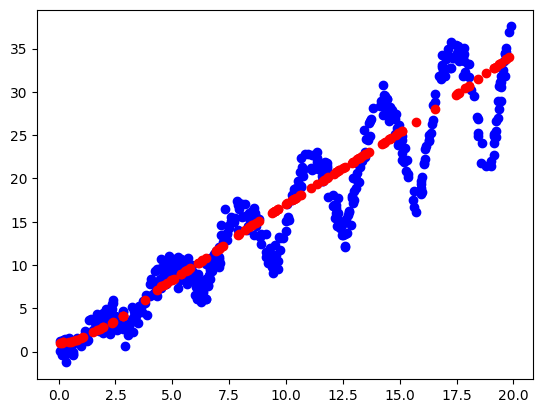

In [ ]:
plt.clf()

assert y.shape == x.shape
plt.scatter(x, y, c ="blue")

assert x_val.shape == y_val.shape
plt.scatter(x_val, model(x_val.to("cuda:0")).detach().to("cpu").numpy(), c="red")